# Experiment Tracking

In [1]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

import xgboost as xgb

from hyperopt import fmin, hp, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope

import pickle

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

## Data Preprocessing

In [3]:
def import_data(url):
  return pd.read_parquet(url)

In [4]:
def process_data(df):
  df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).apply(lambda x: x.total_seconds() / 60)
  df = df.loc[(df.duration >= 1) & (df.duration <= 60), :]

  return df

In [5]:
def prepare_features(df, dv=None):
  categorical_variables = ['PULocationID', 'DOLocationID']
  numerical_variables = ['trip_distance']

  df[categorical_variables] = df[categorical_variables].astype(str)
  df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']

  input_variables = ['PU_DO', 'trip_distance']
  # input_variables = ['PULocationID', 'DOLocationID']

  df_dicts = df[input_variables].to_dict(orient="records")

  if dv:
    X = dv.transform(df_dicts)
  else:
    dv = DictVectorizer()
    X = dv.fit_transform(df_dicts)
  
  y = df.duration.values

  return X, y, dv

In [6]:
def compute_error(X, y, model):
  preds = model.predict(X)
  return root_mean_squared_error(preds, y)

In [7]:
def plot_distribution(df, vars):
  for var in vars:
    sns.kdeplot(data=df, x=var, fill=True)

In [8]:
url_train = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"
url_val = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet"

df_train = import_data(url_train)
df_val = import_data(url_val)

df_train = process_data(df_train)
df_val = process_data(df_val)

X_train, y_train, dv = prepare_features(df_train)
X_val, y_val, _ = prepare_features(df_val, dv)

## Manual Logging

In [9]:
TRACKING_URI = "sqlite:///mlflow.db"
EXPERIMENT_NAME = "nyc-taxi-experiment"

In [10]:
# mlflow ui --backend-store-uri sqlite:///mlflow.db
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1722064660936, experiment_id='1', last_update_time=1722064660936, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

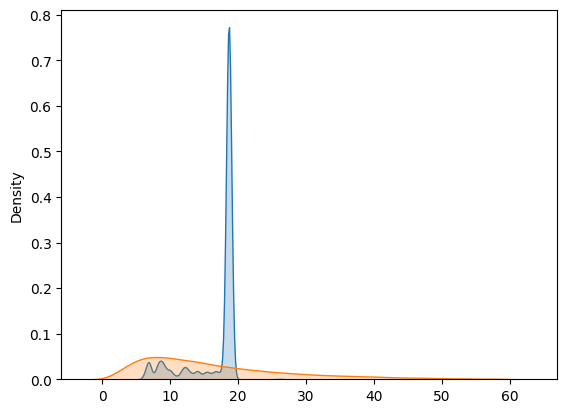

In [11]:
alpha = .01
model = Lasso(alpha)
model.fit(X=X_train, y=y_train)
rmse = compute_error(X=X_val, y=y_val, model=model)

preds = model.predict(X=X_train)
sns.kdeplot(preds, fill=True)
sns.kdeplot(data=y_train, fill=True)

with open("models/lin_reg.bin", "wb") as f_out:
  pickle.dump((dv, model), f_out)

with mlflow.start_run():
  mlflow.set_tag("developer", "Bastien Winant")

  mlflow.log_params({
    "train_data": url_train,
    "val_data": url_val,
    "alpha": alpha
  })

  mlflow.log_metric("rmse", rmse)

## Parameter Optimization

In [12]:
train = xgb.DMatrix(data=X_train, label=y_train)
valid = xgb.DMatrix(data=X_val, label=y_val)

In [13]:
def objective(params):
  booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
  )
  y_pred = booster.predict(valid)
  rmse = root_mean_squared_error(y_val, y_pred)

  with mlflow.start_run():
    mlflow.set_tag("model", "xgboost")
    mlflow.log_params(params)
    mlflow.log_metric("rmse", rmse)
  
  return {"loss": rmse, "status": STATUS_OK}

In [14]:
search_space = {
  "max_depth": scope.int(hp.quniform('max_depth', 4, 100, 1)),
  "learning_rate": hp.loguniform("learning_rate", -3, 0),
  "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
  "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
  "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
  "objective": "reg:linear",
  "seed": 42
}

best_result = fmin(
  fn=objective,
  space=search_space,
  algo=tpe.suggest,
  max_evals=50,
  trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:30:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.15424                          
[1]	validation-rmse:8.83208                           
[2]	validation-rmse:8.01066                           
[3]	validation-rmse:7.51520                           
[4]	validation-rmse:7.21561                           
[5]	validation-rmse:7.03870                           
[6]	validation-rmse:6.92900                           
[7]	validation-rmse:6.86147                           
[8]	validation-rmse:6.81721                           
[9]	validation-rmse:6.78322                           
[10]	validation-rmse:6.75882                          
[11]	validation-rmse:6.74330                          
[12]	validation-rmse:6.72998                          
[13]	validation-rmse:6.71466                          
[14]	validation-rmse:6.70468                          
[15]	validation-rmse:6.69734                          
[16]	validation-rmse:6.69293                          
[17]	validation-rmse:6.68878                          
[18]	valid

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:31:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.74796                                                   
[1]	validation-rmse:6.55570                                                   
[2]	validation-rmse:6.52972                                                   
[3]	validation-rmse:6.50694                                                   
[4]	validation-rmse:6.49819                                                   
[5]	validation-rmse:6.48614                                                   
[6]	validation-rmse:6.47348                                                   
[7]	validation-rmse:6.46385                                                   
[8]	validation-rmse:6.45818                                                   
[9]	validation-rmse:6.45455                                                   
[10]	validation-rmse:6.44922                                                  
[11]	validation-rmse:6.44683                                                  
[12]	validation-rmse:6.44102                        

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.32127                                                    
[1]	validation-rmse:6.78938                                                    
[2]	validation-rmse:6.70183                                                    
[3]	validation-rmse:6.68107                                                    
[4]	validation-rmse:6.66443                                                    
[5]	validation-rmse:6.65833                                                    
[6]	validation-rmse:6.65060                                                    
[7]	validation-rmse:6.64638                                                    
[8]	validation-rmse:6.63135                                                    
[9]	validation-rmse:6.62738                                                    
[10]	validation-rmse:6.62377                                                   
[11]	validation-rmse:6.62366                                                   
[12]	validation-rmse:6.62016            

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:31:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:11.04022                                                   
[3]	validation-rmse:10.70323                                                   
[4]	validation-rmse:10.39183                                                   
[5]	validation-rmse:10.10241                                                   
[6]	validation-rmse:9.83572                                                    
[7]	validation-rmse:9.58959                                                    
[8]	validation-rmse:9.36166                                                    
[9]	validation-rmse:9.15267                                                    
[10]	validation-rmse:8.95863                                                   
[11]	validation-rmse:8.78126                                                   
[12]	validation-rmse:8.61892                                                   
[13]	validation-rmse:8.46966                                                   
[14]	validation-rmse:8.33284            

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:32:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.53312                                                   
[1]	validation-rmse:10.92844                                                   
[2]	validation-rmse:10.39186                                                   
[3]	validation-rmse:9.91889                                                    
[4]	validation-rmse:9.49854                                                    
[5]	validation-rmse:9.13245                                                    
[6]	validation-rmse:8.80764                                                    
[7]	validation-rmse:8.52434                                                    
[8]	validation-rmse:8.27650                                                    
[9]	validation-rmse:8.05789                                                    
[10]	validation-rmse:7.87113                                                   
[11]	validation-rmse:7.70549                                                   
[12]	validation-rmse:7.56152            

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:34:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.13657                                                  
[1]	validation-rmse:10.25080                                                  
[2]	validation-rmse:9.52669                                                   
[3]	validation-rmse:8.93965                                                   
[4]	validation-rmse:8.46766                                                   
[5]	validation-rmse:8.09058                                                   
[6]	validation-rmse:7.78949                                                   
[7]	validation-rmse:7.55129                                                   
[8]	validation-rmse:7.36364                                                   
[9]	validation-rmse:7.21372                                                   
[10]	validation-rmse:7.09602                                                  
[11]	validation-rmse:7.00003                                                  
[12]	validation-rmse:6.92258                        

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:36:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.36175                                                  
[1]	validation-rmse:9.10123                                                   
[2]	validation-rmse:8.26584                                                   
[3]	validation-rmse:7.72452                                                   
[4]	validation-rmse:7.37597                                                   
[5]	validation-rmse:7.15448                                                   
[6]	validation-rmse:7.01168                                                   
[7]	validation-rmse:6.92058                                                   
[8]	validation-rmse:6.85642                                                   
[9]	validation-rmse:6.81156                                                   
[10]	validation-rmse:6.78131                                                  
[11]	validation-rmse:6.75828                                                  
[12]	validation-rmse:6.74134                        

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:37:25] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77215                                                  
[1]	validation-rmse:11.36179                                                  
[2]	validation-rmse:10.98055                                                  
[3]	validation-rmse:10.62676                                                  
[4]	validation-rmse:10.29875                                                  
[5]	validation-rmse:9.99521                                                   
[6]	validation-rmse:9.71439                                                   
[7]	validation-rmse:9.45532                                                   
[8]	validation-rmse:9.21554                                                   
[9]	validation-rmse:8.99453                                                   
[10]	validation-rmse:8.79105                                                  
[11]	validation-rmse:8.60383                                                  
[12]	validation-rmse:8.43197                        

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:38:55] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.40837                                                    
[1]	validation-rmse:7.21704                                                    
[2]	validation-rmse:6.86225                                                    
[3]	validation-rmse:6.73795                                                    
[4]	validation-rmse:6.68373                                                    
[5]	validation-rmse:6.66007                                                    
[6]	validation-rmse:6.64245                                                    
[7]	validation-rmse:6.62807                                                    
[8]	validation-rmse:6.62441                                                    
[9]	validation-rmse:6.62081                                                    
[10]	validation-rmse:6.61519                                                   
[11]	validation-rmse:6.61219                                                   
[12]	validation-rmse:6.60909            

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:39:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.05655                                                    
[2]	validation-rmse:7.36568                                                    
[3]	validation-rmse:7.03621                                                    
[4]	validation-rmse:6.87542                                                    
[5]	validation-rmse:6.79300                                                    
[6]	validation-rmse:6.74814                                                    
[7]	validation-rmse:6.72296                                                    
[8]	validation-rmse:6.70657                                                    
[9]	validation-rmse:6.69991                                                    
[10]	validation-rmse:6.69069                                                   
[11]	validation-rmse:6.68713                                                   
[12]	validation-rmse:6.68138                                                   
[13]	validation-rmse:6.67804            

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:40:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.92790                                                    
[1]	validation-rmse:9.91727                                                     
[2]	validation-rmse:9.13268                                                     
[3]	validation-rmse:8.52943                                                     
[4]	validation-rmse:8.07091                                                     
[5]	validation-rmse:7.72370                                                     
[6]	validation-rmse:7.46048                                                     
[7]	validation-rmse:7.26499                                                     
[8]	validation-rmse:7.11858                                                     
[9]	validation-rmse:7.00795                                                     
[10]	validation-rmse:6.92439                                                    
[11]	validation-rmse:6.86083                                                    
[12]	validation-rmse:6.81178

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.97040                                                     
[1]	validation-rmse:7.55563                                                     
[2]	validation-rmse:6.97941                                                     
[3]	validation-rmse:6.74339                                                     
[4]	validation-rmse:6.64077                                                     
[5]	validation-rmse:6.58330                                                     
[6]	validation-rmse:6.55273                                                     
[7]	validation-rmse:6.53532                                                     
[8]	validation-rmse:6.52091                                                     
[9]	validation-rmse:6.50762                                                     
[10]	validation-rmse:6.50361                                                    
[11]	validation-rmse:6.49992                                                    
[12]	validation-rmse:6.49435

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.72417                                                    
[1]	validation-rmse:11.27362                                                    
[2]	validation-rmse:10.86037                                                    
[3]	validation-rmse:10.47785                                                    
[4]	validation-rmse:10.12974                                                    
[5]	validation-rmse:9.80675                                                     
[6]	validation-rmse:9.51517                                                     
[7]	validation-rmse:9.24532                                                     
[8]	validation-rmse:9.00267                                                     
[9]	validation-rmse:8.77918                                                     
[10]	validation-rmse:8.57495                                                    
[11]	validation-rmse:8.38845                                                    
[12]	validation-rmse:8.22350

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:45:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.36438                                                     
[1]	validation-rmse:7.92337                                                     
[2]	validation-rmse:7.24004                                                     
[3]	validation-rmse:6.92272                                                     
[4]	validation-rmse:6.77284                                                     
[5]	validation-rmse:6.69093                                                     
[6]	validation-rmse:6.64662                                                     
[7]	validation-rmse:6.61873                                                     
[8]	validation-rmse:6.60279                                                     
[9]	validation-rmse:6.59174                                                     
[10]	validation-rmse:6.58099                                                    
[11]	validation-rmse:6.57860                                                    
[12]	validation-rmse:6.57454

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:45:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.63196                                                     
[1]	validation-rmse:7.29834                                                     
[2]	validation-rmse:6.83765                                                     
[3]	validation-rmse:6.67049                                                     
[4]	validation-rmse:6.59439                                                     
[5]	validation-rmse:6.55232                                                     
[6]	validation-rmse:6.53227                                                     
[7]	validation-rmse:6.51674                                                     
[8]	validation-rmse:6.50257                                                     
[9]	validation-rmse:6.49791                                                     
[10]	validation-rmse:6.49455                                                    
[11]	validation-rmse:6.49136                                                    
[12]	validation-rmse:6.48596

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80747                                                     
[1]	validation-rmse:7.42867                                                     
[2]	validation-rmse:6.91688                                                     
[3]	validation-rmse:6.71178                                                     
[4]	validation-rmse:6.62349                                                     
[5]	validation-rmse:6.57687                                                     
[6]	validation-rmse:6.54760                                                     
[7]	validation-rmse:6.53368                                                     
[8]	validation-rmse:6.52740                                                     
[9]	validation-rmse:6.52408                                                     
[10]	validation-rmse:6.51981                                                    
[11]	validation-rmse:6.51493                                                    
[12]	validation-rmse:6.50907

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.44749                                                    
[1]	validation-rmse:10.77591                                                    
[2]	validation-rmse:10.18890                                                    
[3]	validation-rmse:9.67868                                                     
[4]	validation-rmse:9.23484                                                     
[5]	validation-rmse:8.85177                                                     
[6]	validation-rmse:8.52106                                                     
[7]	validation-rmse:8.23684                                                     
[8]	validation-rmse:7.99298                                                     
[9]	validation-rmse:7.78455                                                     
[10]	validation-rmse:7.60671                                                    
[11]	validation-rmse:7.45488                                                    
[12]	validation-rmse:7.32618

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:48:08] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.82820                                                     
[1]	validation-rmse:8.42877                                                     
[2]	validation-rmse:7.63722                                                     
[3]	validation-rmse:7.20341                                                     
[4]	validation-rmse:6.96771                                                     
[5]	validation-rmse:6.83048                                                     
[6]	validation-rmse:6.74972                                                     
[7]	validation-rmse:6.70341                                                     
[8]	validation-rmse:6.67376                                                     
[9]	validation-rmse:6.65181                                                     
[10]	validation-rmse:6.63770                                                    
[11]	validation-rmse:6.62912                                                    
[12]	validation-rmse:6.62389

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:49:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.11790                                                     
[1]	validation-rmse:10.21864                                                     
[2]	validation-rmse:9.48787                                                      
[3]	validation-rmse:8.90240                                                      
[4]	validation-rmse:8.43128                                                      
[5]	validation-rmse:8.05011                                                      
[6]	validation-rmse:7.75434                                                      
[7]	validation-rmse:7.51878                                                      
[8]	validation-rmse:7.32276                                                      
[9]	validation-rmse:7.17795                                                      
[10]	validation-rmse:7.05889                                                     
[11]	validation-rmse:6.96680                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:50:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.32018                                                      
[1]	validation-rmse:7.88959                                                      
[2]	validation-rmse:7.22702                                                      
[3]	validation-rmse:6.91807                                                      
[4]	validation-rmse:6.76351                                                      
[5]	validation-rmse:6.68113                                                      
[6]	validation-rmse:6.63922                                                      
[7]	validation-rmse:6.61397                                                      
[8]	validation-rmse:6.59861                                                      
[9]	validation-rmse:6.58638                                                      
[10]	validation-rmse:6.57580                                                     
[11]	validation-rmse:6.57019                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.69451                                                      
[1]	validation-rmse:6.84674                                                      
[2]	validation-rmse:6.66944                                                      
[3]	validation-rmse:6.62135                                                      
[4]	validation-rmse:6.60460                                                      
[5]	validation-rmse:6.59304                                                      
[6]	validation-rmse:6.58717                                                      
[7]	validation-rmse:6.58389                                                      
[8]	validation-rmse:6.57746                                                      
[9]	validation-rmse:6.57277                                                      
[10]	validation-rmse:6.56628                                                     
[11]	validation-rmse:6.56328                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.78294                                                      
[3]	validation-rmse:7.35427                                                      
[4]	validation-rmse:7.11664                                                      
[5]	validation-rmse:6.98440                                                      
[6]	validation-rmse:6.90732                                                      
[7]	validation-rmse:6.86355                                                      
[8]	validation-rmse:6.83307                                                      
[9]	validation-rmse:6.81483                                                      
[10]	validation-rmse:6.80099                                                     
[11]	validation-rmse:6.78961                                                     
[12]	validation-rmse:6.78570                                                     
[13]	validation-rmse:6.78278                                                     
[14]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.57548                                                     
[1]	validation-rmse:9.38079                                                      
[2]	validation-rmse:8.52594                                                      
[3]	validation-rmse:7.92397                                                      
[4]	validation-rmse:7.50669                                                      
[5]	validation-rmse:7.21557                                                      
[6]	validation-rmse:7.01535                                                      
[7]	validation-rmse:6.87483                                                      
[8]	validation-rmse:6.77652                                                      
[9]	validation-rmse:6.70554                                                      
[10]	validation-rmse:6.65361                                                     
[11]	validation-rmse:6.61464                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:54:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.64399                                                     
[1]	validation-rmse:9.48579                                                      
[2]	validation-rmse:8.64475                                                      
[3]	validation-rmse:8.04330                                                      
[4]	validation-rmse:7.62018                                                      
[5]	validation-rmse:7.32238                                                      
[6]	validation-rmse:7.11594                                                      
[7]	validation-rmse:6.96881                                                      
[8]	validation-rmse:6.86278                                                      
[9]	validation-rmse:6.78743                                                      
[10]	validation-rmse:6.73130                                                     
[11]	validation-rmse:6.69116                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:55:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.75433                                                    
[1]	validation-rmse:9.65386                                                     
[2]	validation-rmse:8.83456                                                     
[3]	validation-rmse:8.23277                                                     
[4]	validation-rmse:7.79566                                                     
[5]	validation-rmse:7.48640                                                     
[6]	validation-rmse:7.25459                                                     
[7]	validation-rmse:7.09352                                                     
[8]	validation-rmse:6.97670                                                     
[9]	validation-rmse:6.89052                                                     
[10]	validation-rmse:6.82459                                                    
[11]	validation-rmse:6.77498                                                    
[12]	validation-rmse:6.73920

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:56:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.67937                                                    
[2]	validation-rmse:10.06804                                                    
[3]	validation-rmse:9.54505                                                     
[4]	validation-rmse:9.09881                                                     
[5]	validation-rmse:8.72117                                                     
[6]	validation-rmse:8.40201                                                     
[7]	validation-rmse:8.13210                                                     
[8]	validation-rmse:7.90624                                                     
[9]	validation-rmse:7.71700                                                     
[10]	validation-rmse:7.55615                                                    
[11]	validation-rmse:7.42245                                                    
[12]	validation-rmse:7.30923                                                    
[13]	validation-rmse:7.21605

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.11106                                                    
[1]	validation-rmse:8.75660                                                     
[2]	validation-rmse:7.91150                                                     
[3]	validation-rmse:7.39746                                                     
[4]	validation-rmse:7.08692                                                     
[5]	validation-rmse:6.89793                                                     
[6]	validation-rmse:6.77780                                                     
[7]	validation-rmse:6.70297                                                     
[8]	validation-rmse:6.65227                                                     
[9]	validation-rmse:6.61772                                                     
[10]	validation-rmse:6.59540                                                    
[11]	validation-rmse:6.57543                                                    
[12]	validation-rmse:6.56315

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.00819                                                    
[1]	validation-rmse:10.03933                                                    
[2]	validation-rmse:9.26703                                                     
[3]	validation-rmse:8.65578                                                     
[4]	validation-rmse:8.18009                                                     
[5]	validation-rmse:7.80842                                                     
[6]	validation-rmse:7.52071                                                     
[7]	validation-rmse:7.29944                                                     
[8]	validation-rmse:7.12576                                                     
[9]	validation-rmse:6.99209                                                     
[10]	validation-rmse:6.88974                                                    
[11]	validation-rmse:6.81218                                                    
[12]	validation-rmse:6.75018

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:00:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.01523                                                    
[1]	validation-rmse:8.65220                                                     
[2]	validation-rmse:7.83523                                                     
[3]	validation-rmse:7.35828                                                     
[4]	validation-rmse:7.07913                                                     
[5]	validation-rmse:6.91648                                                     
[6]	validation-rmse:6.81722                                                     
[7]	validation-rmse:6.75812                                                     
[8]	validation-rmse:6.72320                                                     
[9]	validation-rmse:6.69947                                                     
[10]	validation-rmse:6.68098                                                    
[11]	validation-rmse:6.66933                                                    
[12]	validation-rmse:6.66015

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:01:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.28409                                                     
[2]	validation-rmse:8.45591                                                     
[3]	validation-rmse:7.90103                                                     
[4]	validation-rmse:7.53339                                                     
[5]	validation-rmse:7.28680                                                     
[6]	validation-rmse:7.12625                                                     
[7]	validation-rmse:7.01857                                                     
[8]	validation-rmse:6.94653                                                     
[9]	validation-rmse:6.89906                                                     
[10]	validation-rmse:6.86802                                                    
[11]	validation-rmse:6.84342                                                    
[12]	validation-rmse:6.82577                                                    
[13]	validation-rmse:6.81200

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:01:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.26527                                                    
[1]	validation-rmse:10.46414                                                    
[2]	validation-rmse:9.78641                                                     
[3]	validation-rmse:9.22027                                                     
[4]	validation-rmse:8.74700                                                     
[5]	validation-rmse:8.35598                                                     
[6]	validation-rmse:8.03237                                                     
[7]	validation-rmse:7.76484                                                     
[8]	validation-rmse:7.54862                                                     
[9]	validation-rmse:7.36732                                                     
[10]	validation-rmse:7.22005                                                    
[11]	validation-rmse:7.10047                                                    
[12]	validation-rmse:7.00083

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.57672                                                    
[1]	validation-rmse:11.00435                                                    
[2]	validation-rmse:10.49012                                                    
[3]	validation-rmse:10.02991                                                    
[4]	validation-rmse:9.61873                                                     
[5]	validation-rmse:9.25209                                                     
[6]	validation-rmse:8.92542                                                     
[7]	validation-rmse:8.63511                                                     
[8]	validation-rmse:8.37987                                                     
[9]	validation-rmse:8.15409                                                     
[10]	validation-rmse:7.95348                                                    
[11]	validation-rmse:7.77826                                                    
[12]	validation-rmse:7.62313

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:06:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.33625                                                    
[1]	validation-rmse:10.58310                                                    
[2]	validation-rmse:9.93804                                                     
[3]	validation-rmse:9.39008                                                     
[4]	validation-rmse:8.92445                                                     
[5]	validation-rmse:8.53191                                                     
[6]	validation-rmse:8.20167                                                     
[7]	validation-rmse:7.92636                                                     
[8]	validation-rmse:7.69697                                                     
[9]	validation-rmse:7.50578                                                     
[10]	validation-rmse:7.34628                                                    
[11]	validation-rmse:7.21172                                                    
[12]	validation-rmse:7.10021

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.25809                                                      
[1]	validation-rmse:10.44729                                                      
[2]	validation-rmse:9.76475                                                       
[3]	validation-rmse:9.19373                                                       
[4]	validation-rmse:8.71402                                                       
[5]	validation-rmse:8.32098                                                       
[6]	validation-rmse:7.99230                                                       
[7]	validation-rmse:7.72290                                                       
[8]	validation-rmse:7.50407                                                       
[9]	validation-rmse:7.32357                                                       
[10]	validation-rmse:7.17580                                                      
[11]	validation-rmse:7.05417                                                      
[12]

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:09:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.63402                                                     
[1]	validation-rmse:11.11042                                                     
[2]	validation-rmse:10.63471                                                     
[3]	validation-rmse:10.20671                                                     
[4]	validation-rmse:9.82058                                                      
[5]	validation-rmse:9.47338                                                      
[6]	validation-rmse:9.16104                                                      
[7]	validation-rmse:8.88325                                                      
[8]	validation-rmse:8.63574                                                      
[9]	validation-rmse:8.40935                                                      
[10]	validation-rmse:8.21260                                                     
[11]	validation-rmse:8.03528                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:11:23] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.67960                                                      
[1]	validation-rmse:11.19187                                                      
[2]	validation-rmse:10.74865                                                      
[3]	validation-rmse:10.34176                                                      
[4]	validation-rmse:9.97479                                                       
[5]	validation-rmse:9.64086                                                       
[6]	validation-rmse:9.33766                                                       
[7]	validation-rmse:9.06089                                                       
[8]	validation-rmse:8.81616                                                       
[9]	validation-rmse:8.59129                                                       
[10]	validation-rmse:8.39118                                                      
[11]	validation-rmse:8.20371                                                      
[12]

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:14:14] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.22849                                                      
[1]	validation-rmse:10.39966                                                      
[2]	validation-rmse:9.70553                                                       
[3]	validation-rmse:9.12834                                                       
[4]	validation-rmse:8.64842                                                       
[5]	validation-rmse:8.25556                                                       
[6]	validation-rmse:7.93244                                                       
[7]	validation-rmse:7.66954                                                       
[8]	validation-rmse:7.45462                                                       
[9]	validation-rmse:7.28065                                                       
[10]	validation-rmse:7.13767                                                      
[11]	validation-rmse:7.02332                                                      
[12]

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:15:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.46762                                                      
[1]	validation-rmse:10.81198                                                      
[2]	validation-rmse:10.23823                                                      
[3]	validation-rmse:9.73722                                                       
[4]	validation-rmse:9.30106                                                       
[5]	validation-rmse:8.92300                                                       
[6]	validation-rmse:8.59686                                                       
[7]	validation-rmse:8.31580                                                       
[8]	validation-rmse:8.07384                                                       
[9]	validation-rmse:7.86647                                                       
[10]	validation-rmse:7.68900                                                      
[11]	validation-rmse:7.53726                                                      
[12]

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:17:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.84582                                                      
[1]	validation-rmse:9.78996                                                       
[2]	validation-rmse:8.98322                                                       
[3]	validation-rmse:8.37299                                                       
[4]	validation-rmse:7.91160                                                       
[5]	validation-rmse:7.57493                                                       
[6]	validation-rmse:7.32238                                                       
[7]	validation-rmse:7.13746                                                       
[8]	validation-rmse:7.00285                                                       
[9]	validation-rmse:6.89321                                                       
[10]	validation-rmse:6.81462                                                      
[11]	validation-rmse:6.75616                                                      
[12]

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:18:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80666                                                     
[1]	validation-rmse:11.42596                                                     
[2]	validation-rmse:11.07025                                                     
[3]	validation-rmse:10.73814                                                     
[4]	validation-rmse:10.42800                                                     
[5]	validation-rmse:10.13928                                                     
[6]	validation-rmse:9.87033                                                      
[7]	validation-rmse:9.61962                                                      
[8]	validation-rmse:9.38644                                                      
[9]	validation-rmse:9.16987                                                      
[10]	validation-rmse:8.96879                                                     
[11]	validation-rmse:8.78248                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:20:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.60010                                                      
[1]	validation-rmse:6.57466                                                      
[2]	validation-rmse:6.57472                                                      
[3]	validation-rmse:6.56638                                                      
[4]	validation-rmse:6.56302                                                      
[5]	validation-rmse:6.54409                                                      
[6]	validation-rmse:6.53990                                                      
[7]	validation-rmse:6.53127                                                      
[8]	validation-rmse:6.52451                                                      
[9]	validation-rmse:6.51973                                                      
[10]	validation-rmse:6.51780                                                     
[11]	validation-rmse:6.51400                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:20:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.52041                                                     
[1]	validation-rmse:10.90401                                                     
[2]	validation-rmse:10.35654                                                     
[3]	validation-rmse:9.87248                                                      
[4]	validation-rmse:9.44468                                                      
[5]	validation-rmse:9.06895                                                      
[6]	validation-rmse:8.73899                                                      
[7]	validation-rmse:8.44951                                                      
[8]	validation-rmse:8.19736                                                      
[9]	validation-rmse:7.97704                                                      
[10]	validation-rmse:7.78581                                                     
[11]	validation-rmse:7.62010                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:22:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.31770                                                     
[1]	validation-rmse:10.55450                                                     
[2]	validation-rmse:9.90802                                                      
[3]	validation-rmse:9.35299                                                      
[4]	validation-rmse:8.89612                                                      
[5]	validation-rmse:8.50741                                                      
[6]	validation-rmse:8.18429                                                      
[7]	validation-rmse:7.91220                                                      
[8]	validation-rmse:7.68812                                                      
[9]	validation-rmse:7.50072                                                      
[10]	validation-rmse:7.34778                                                     
[11]	validation-rmse:7.21889                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:23:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.73196                                                     
[1]	validation-rmse:11.28762                                                     
[2]	validation-rmse:10.87814                                                     
[3]	validation-rmse:10.50092                                                     
[4]	validation-rmse:10.15393                                                     
[5]	validation-rmse:9.83535                                                      
[6]	validation-rmse:9.54316                                                      
[7]	validation-rmse:9.27557                                                      
[8]	validation-rmse:9.03051                                                      
[9]	validation-rmse:8.80706                                                      
[10]	validation-rmse:8.60273                                                     
[11]	validation-rmse:8.41642                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:25:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.10054                                                     
[1]	validation-rmse:10.19503                                                     
[2]	validation-rmse:9.46475                                                      
[3]	validation-rmse:8.88056                                                      
[4]	validation-rmse:8.41753                                                      
[5]	validation-rmse:8.05194                                                      
[6]	validation-rmse:7.76562                                                      
[7]	validation-rmse:7.54049                                                      
[8]	validation-rmse:7.36490                                                      
[9]	validation-rmse:7.22841                                                      
[10]	validation-rmse:7.12197                                                     
[11]	validation-rmse:7.03929                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:26:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.62116                                                     
[1]	validation-rmse:11.08648                                                     
[2]	validation-rmse:10.60451                                                     
[3]	validation-rmse:10.17100                                                     
[4]	validation-rmse:9.78193                                                      
[5]	validation-rmse:9.43305                                                      
[6]	validation-rmse:9.12142                                                      
[7]	validation-rmse:8.84374                                                      
[8]	validation-rmse:8.59614                                                      
[9]	validation-rmse:8.37622                                                      
[10]	validation-rmse:8.18106                                                     
[11]	validation-rmse:8.00808                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:28:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.31988                                                     
[1]	validation-rmse:9.03551                                                      
[2]	validation-rmse:8.18519                                                      
[3]	validation-rmse:7.60978                                                      
[4]	validation-rmse:7.25154                                                      
[5]	validation-rmse:7.01912                                                      
[6]	validation-rmse:6.86362                                                      
[7]	validation-rmse:6.76753                                                      
[8]	validation-rmse:6.69420                                                      
[9]	validation-rmse:6.64646                                                      
[10]	validation-rmse:6.61439                                                     
[11]	validation-rmse:6.58851                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:29:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.90188                                                     
[1]	validation-rmse:9.87433                                                      
[2]	validation-rmse:9.07833                                                      
[3]	validation-rmse:8.46837                                                      
[4]	validation-rmse:8.00566                                                      
[5]	validation-rmse:7.65753                                                      
[6]	validation-rmse:7.39739                                                      
[7]	validation-rmse:7.20207                                                      
[8]	validation-rmse:7.05676                                                      
[9]	validation-rmse:6.94610                                                      
[10]	validation-rmse:6.86355                                                     
[11]	validation-rmse:6.80061                                                     
[12]	validation-

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:30:38] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.42859                                                       
[1]	validation-rmse:10.74400                                                       
[2]	validation-rmse:10.14928                                                       
[3]	validation-rmse:9.63508                                                        
[4]	validation-rmse:9.19123                                                        
[5]	validation-rmse:8.81004                                                        
[6]	validation-rmse:8.48410                                                        
[7]	validation-rmse:8.20603                                                        
[8]	validation-rmse:7.96931                                                        
[9]	validation-rmse:7.76757                                                        
[10]	validation-rmse:7.59710                                                       
[11]	validation-rmse:7.45237                                                

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.21909                                                       
[1]	validation-rmse:10.38759                                                       
[2]	validation-rmse:9.69831                                                        
[3]	validation-rmse:9.12107                                                        
[4]	validation-rmse:8.66085                                                        
[5]	validation-rmse:8.26662                                                        
[6]	validation-rmse:7.95207                                                        
[7]	validation-rmse:7.69811                                                        
[8]	validation-rmse:7.48924                                                        
[9]	validation-rmse:7.32059                                                        
[10]	validation-rmse:7.18497                                                       
[11]	validation-rmse:7.07662                                                

## Autologging

In [15]:
mlflow.autolog()

best_params = {
  "learning_rate": 0.24652444714834656,
  "max_depth": 29,
  "min_child_weight": 1.1682881267480025,
  "objective": "reg:linear",
  "reg_alpha": 0.00893306763442688,
  "reg_lambda": 0.0933022543477394,
  "seed": 42
}

booster = xgb.train(
  params=best_params,
  dtrain=train,
  num_boost_round=1000,
  evals=[(valid, "validation")],
  early_stopping_rounds=50
)

2024/07/27 12:34:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/07/27 12:34:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/07/27 12:34:46 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2024/07/27 12:34:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/07/27 12:34:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '65e2b7cff51b418bb07dfa32bb4b6d86', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/s

[0]	validation-rmse:10.29121
[1]	validation-rmse:8.98927
[2]	validation-rmse:8.13170
[3]	validation-rmse:7.58109
[4]	validation-rmse:7.22577
[5]	validation-rmse:6.99645
[6]	validation-rmse:6.85123
[7]	validation-rmse:6.75591
[8]	validation-rmse:6.69024
[9]	validation-rmse:6.64305
[10]	validation-rmse:6.60963
[11]	validation-rmse:6.58568
[12]	validation-rmse:6.56775
[13]	validation-rmse:6.55408
[14]	validation-rmse:6.54353
[15]	validation-rmse:6.53723
[16]	validation-rmse:6.53190
[17]	validation-rmse:6.52994
[18]	validation-rmse:6.52636
[19]	validation-rmse:6.52544
[20]	validation-rmse:6.52242
[21]	validation-rmse:6.52046
[22]	validation-rmse:6.51850
[23]	validation-rmse:6.51502
[24]	validation-rmse:6.51319
[25]	validation-rmse:6.51177
[26]	validation-rmse:6.50873
[27]	validation-rmse:6.50695
[28]	validation-rmse:6.50513
[29]	validation-rmse:6.50263
[30]	validation-rmse:6.49867
[31]	validation-rmse:6.49681
[32]	validation-rmse:6.49551
[33]	validation-rmse:6.49334
[34]	validation-rmse:6.

2024/07/27 12:36:35 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/07/27 12:36:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:36:35] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."


# Model Management
## Manual model logging

In [16]:
mlflow.autolog(disable=True)

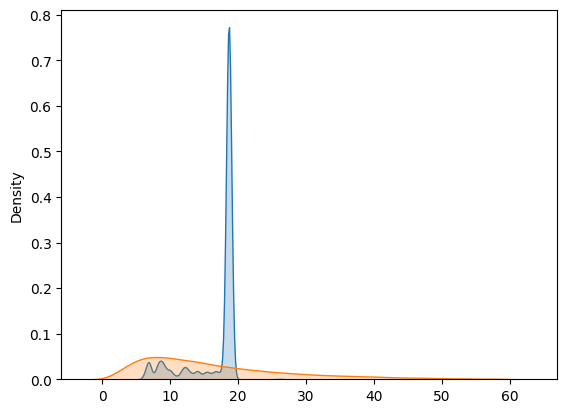

In [17]:
alpha = .01
model = Lasso(alpha)
model.fit(X=X_train, y=y_train)
rmse = compute_error(X=X_val, y=y_val, model=model)

preds = model.predict(X=X_train)
sns.kdeplot(preds, fill=True)
sns.kdeplot(data=y_train, fill=True)

with open("models/lin_reg.bin", "wb") as f_out:
  pickle.dump((dv, model), f_out)

with mlflow.start_run():
  mlflow.set_tag("developer", "Bastien Winant")

  mlflow.log_params({
    "train_data": url_train,
    "val_data": url_val,
    "alpha": alpha
  })

  mlflow.log_metric("rmse", rmse)

  mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [18]:
best_params = {
  "learning_rate": 0.24652444714834656,
  "max_depth": 29,
  "min_child_weight": 1.1682881267480025,
  "objective": "reg:linear",
  "reg_alpha": 0.00893306763442688,
  "reg_lambda": 0.0933022543477394,
  "seed": 42
}

booster = xgb.train(
  params=best_params,
  dtrain=train,
  num_boost_round=1000,
  evals=[(valid, "validation")],
  early_stopping_rounds=50
)
y_pred = booster.predict(valid)
rmse = root_mean_squared_error(y_val, y_pred)

with open("models/preprocessor.b", "wb") as f_out:
  pickle.dump(dv, f_out)

with mlflow.start_run():
  mlflow.set_tag("model", "xgboost")
  mlflow.log_params(best_params)
  mlflow.log_metric("rmse", rmse)

  mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
  mlflow.xgboost.log_model(booster, artifact_path="model_mlflow")

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:36:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.29121
[1]	validation-rmse:8.98927
[2]	validation-rmse:8.13170
[3]	validation-rmse:7.58109
[4]	validation-rmse:7.22577
[5]	validation-rmse:6.99645
[6]	validation-rmse:6.85123
[7]	validation-rmse:6.75591
[8]	validation-rmse:6.69024
[9]	validation-rmse:6.64305
[10]	validation-rmse:6.60963
[11]	validation-rmse:6.58568
[12]	validation-rmse:6.56775
[13]	validation-rmse:6.55408
[14]	validation-rmse:6.54353
[15]	validation-rmse:6.53723
[16]	validation-rmse:6.53190
[17]	validation-rmse:6.52994
[18]	validation-rmse:6.52636
[19]	validation-rmse:6.52544
[20]	validation-rmse:6.52242
[21]	validation-rmse:6.52046
[22]	validation-rmse:6.51850
[23]	validation-rmse:6.51502
[24]	validation-rmse:6.51319
[25]	validation-rmse:6.51177
[26]	validation-rmse:6.50873
[27]	validation-rmse:6.50695
[28]	validation-rmse:6.50513
[29]	validation-rmse:6.50263
[30]	validation-rmse:6.49867
[31]	validation-rmse:6.49681
[32]	validation-rmse:6.49551
[33]	validation-rmse:6.49334
[34]	validation-rmse:6.

/Users/bastienwinant/Desktop/Projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:37:30] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


## Model retrieval & prediction

In [19]:
logged_model = 'runs:/791827d84e01457fb7fab1c174903aee/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a pandas DataFrame
loaded_model.predict(X_val)

array([14.389974 ,  6.9996576, 15.522848 , ..., 13.503272 ,  6.551017 ,
        7.9055996], dtype=float32)

In [20]:
# Load model as Booster object.
xgboost_model = mlflow.xgboost.load_model(logged_model)

# Predict on a DMatrix.
xgboost_model.predict(valid)

array([14.389974 ,  6.9996576, 15.522848 , ..., 13.503272 ,  6.551017 ,
        7.9055996], dtype=float32)